# Cropped Upper Half face Recognition

### Author: Xuying Ning
### All copyright reserved.

In [1]:
from facenet_pytorch import MTCNN
import cv2
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchvision import transforms
import numpy as np
import os

In [2]:
class CustomImageDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=ToTensor()):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dira (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = cv2.imread(img_name)
        # image = image.view((224,224,3))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # # image = np.transpose(image,(1,2,0)) 
        label = self.landmarks_frame.iloc[idx, 1]
        label = np.array(label)
        if self.transform:
            image = self.transform(image)
        return image,label

In [3]:
img = torchvision.io.read_image(os.path.join('crop-mask-face/test/',os.listdir('crop-mask-face/test/')[2]))

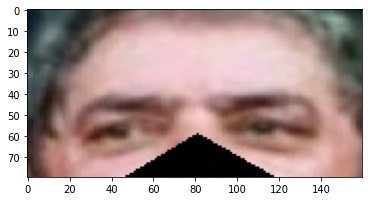

In [4]:
plt.imshow(img.permute(1,2,0))

In [5]:
img.shape

torch.Size([3, 80, 160])

In [6]:
from facenet_pytorch import fixed_image_standardization, training
preprocessing = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    transforms.Resize((160,160)),
    fixed_image_standardization
])

trainset = CustomImageDataset(csv_file = 'train.csv',
                              root_dir='crop-mask-face/train/',
                             transform = preprocessing)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 torch.Size([3, 160, 160])
1 torch.Size([3, 160, 160])
2 torch.Size([3, 160, 160])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 torch.Size([3, 160, 160])


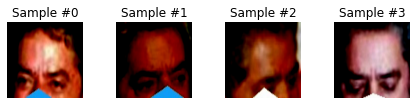

In [7]:
for i in range(len(trainset)):
    data,label = trainset[i]

    print(i, data.shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(data.permute(1,2,0))
    if i == 3:
        plt.show()
        break

In [8]:
from torch.utils.data import DataLoader
trainloader = DataLoader(trainset, batch_size=8,
                        shuffle=True, num_workers=0)

In [9]:
testset = CustomImageDataset(csv_file = 'test.csv',
                              root_dir='crop-mask-face/test/',
                             transform = preprocessing)
testloader = DataLoader(testset, batch_size=8,
                        shuffle=True, num_workers=0)
valset = CustomImageDataset(csv_file = 'val.csv',
                              root_dir='crop-mask-face/val/',
                             transform = preprocessing)
valloader = DataLoader(valset, batch_size=8,
                        shuffle=True, num_workers=0)

In [10]:
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from facenet_pytorch import InceptionResnetV1
from torch import optim
device = "cuda" if torch.cuda.is_available() else "cpu"
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes= 50
).to(device)
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

In [19]:
total_params = sum(
	param.numel() for param in resnet.parameters()
)
total_params

23508274

In [20]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir = 'tf-logs' )
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
epochs = 50
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, valloader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)
ls_i = 1e10

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, trainloader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet.eval()
    ls,mc = training.pass_epoch(
        resnet, loss_fn, valloader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )
    if ls < ls_i:
        torch.save(resnet.state_dict(),'model_parameter0.pth')
        ls_i = ls
        print('! Save Model of', epoch, 'Epoch !')

writer.close()



Initial
----------
Valid |    21/21   | loss:    4.1236 | fps:  107.5632 | acc:    0.0298   

Epoch 1/50
----------
Train |   168/168  | loss:    3.5998 | fps:   78.7311 | acc:    0.1213   
Valid |    21/21   | loss:    2.8452 | fps:  109.9819 | acc:    0.2222   
! Save Model of 0 Epoch !

Epoch 2/50
----------
Train |   168/168  | loss:    2.8794 | fps:   70.7184 | acc:    0.2254   
Valid |    21/21   | loss:    2.5663 | fps:  104.4941 | acc:    0.3433   
! Save Model of 1 Epoch !

Epoch 3/50
----------
Train |   168/168  | loss:    2.4233 | fps:   73.9039 | acc:    0.3326   
Valid |    21/21   | loss:    2.1676 | fps:   88.2844 | acc:    0.4385   
! Save Model of 2 Epoch !

Epoch 4/50
----------
Train |   168/168  | loss:    2.0423 | fps:   77.7732 | acc:    0.4189   
Valid |    21/21   | loss:    1.6643 | fps:  108.8808 | acc:    0.5159   
! Save Model of 3 Epoch !

Epoch 5/50
----------
Train |   168/168  | loss:    1.7137 | fps:   76.4341 | acc:    0.5208   
Valid |    21/21   |

Early stopping by hand

In [22]:
resnet.load_state_dict(torch.load('model_parameter0.pth'), strict=False)
correct = 0
total = 0
sample_count = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i,data in enumerate(testloader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
#         print(labels)
        # calculate outputs by running images through the network
        outputs = resnet(images)
        # the class with the highest energy is what we choose as prediction
        _,predicted  = torch.max(outputs, 1)
#         print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if 0 in (predicted == labels):
            determinant = predicted == labels
            for j in range(len(determinant)):
                if determinant[j] == False:
                    print(f'False Sample {sample_count+1}: True Labels: {labels[j].item()}, Predicted:{predicted[j].item()}')
                    sample_count += 1
                    # plt.imshow(images[j].cpu().permute(1,2,0))

print(f'Accuracy of the network on the 196 test images: {100 * correct // total} %')

False Sample 1: True Labels: 8, Predicted:27
False Sample 2: True Labels: 34, Predicted:33
False Sample 3: True Labels: 4, Predicted:44
False Sample 4: True Labels: 15, Predicted:25
False Sample 5: True Labels: 0, Predicted:21
False Sample 6: True Labels: 35, Predicted:6
False Sample 7: True Labels: 47, Predicted:26
False Sample 8: True Labels: 26, Predicted:34
False Sample 9: True Labels: 19, Predicted:27
False Sample 10: True Labels: 48, Predicted:17
False Sample 11: True Labels: 33, Predicted:23
False Sample 12: True Labels: 13, Predicted:46
False Sample 13: True Labels: 39, Predicted:33
False Sample 14: True Labels: 33, Predicted:0
False Sample 15: True Labels: 43, Predicted:48
False Sample 16: True Labels: 17, Predicted:21
False Sample 17: True Labels: 37, Predicted:33
False Sample 18: True Labels: 2, Predicted:33
False Sample 19: True Labels: 47, Predicted:23
False Sample 20: True Labels: 21, Predicted:6
False Sample 21: True Labels: 4, Predicted:28
False Sample 22: True Labels: 

In [23]:
nb_classes = 50

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = resnet(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
acc_class = confusion_matrix.diag()/confusion_matrix.sum(1)

tensor([[4., 0., 0.,  ..., 0., 0., 0.],
        [0., 6., 0.,  ..., 0., 0., 0.],
        [0., 0., 2.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 2., 0., 0.],
        [0., 0., 0.,  ..., 0., 4., 0.],
        [0., 0., 0.,  ..., 0., 0., 3.]])


In [24]:
conf_m = pd.DataFrame(confusion_matrix)
conf_m.to_csv('confision_matrix.csv')

In [25]:
cl = 0
bad_class  = []
for item in acc_class:
    if item < 0.5:
        bad_class.append(cl)
    cl += 1
print(bad_class)

[4, 37]


In [26]:
testloader = DataLoader(testset, batch_size=1,
                        shuffle=True, num_workers=0)
right_pred_score = []
wrong_pred_score = []
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = resnet(inputs)
        ps = torch.exp(outputs)
        topk, topclass = ps.topk(1, dim=1)
        if i < 5:
            print("Prediction : ", topclass.cpu().numpy()[0][0], ", Score: ", topk.cpu().numpy()[0][0])
        if topclass.cpu().numpy()[0][0] == classes:
            right_pred_score.append(topk.cpu().numpy()[0][0])
        else:
            wrong_pred_score.append(topk.cpu().numpy()[0][0])

Prediction :  31 , Score:  3572416.2
Prediction :  33 , Score:  17018.559
Prediction :  29 , Score:  12691.146
Prediction :  12 , Score:  2715486.5
Prediction :  6 , Score:  16983.326


In [27]:
print(np.percentile(wrong_pred_score,80))
print(np.percentile(right_pred_score,80))

1800.249316406252
275287.90625
